In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results, plot_error, plot_var, plot_cover

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True

In [2]:
dim = 3
corr = 0.

beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
theta = [0., 0., corr]
model.copula_parameters = theta
    
true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [3]:
n_var = 50000
n_outer = 1

n_boot = 1000
n_run = 100

n_n_perms = 30
min_n_perms = 100
max_n_perms = 20000

all_n_perms = np.logspace(np.log10(min_n_perms), np.log10(max_n_perms), n_n_perms, base=10, dtype=int)
assert len(np.unique(all_n_perms)) == n_n_perms,\
    "Wrong number of all_No %d != %d" % (len(np.unique(all_n_perms)), n_n_perms)
    
all_n_inner = [10]
n_n_inner = len(all_n_inner)
method = 'random'

In [4]:
%%time

all_shapley_results = np.zeros((n_n_perms, n_n_inner, n_run, dim, n_boot))
all_first_results = np.zeros((n_n_perms, n_n_inner, n_run, dim, n_boot))
all_total_results = np.zeros((n_n_perms, n_n_inner, n_run, dim, n_boot))

all_shapley_results_SE = np.zeros((n_n_perms, n_n_inner, n_run, dim))
all_first_results_SE = np.zeros((n_n_perms, n_n_inner, n_run, dim))
all_total_results_SE = np.zeros((n_n_perms, n_n_inner, n_run, dim))

for i_outer, n_perms in enumerate(all_n_perms):
    for i_inner, n_inner in enumerate(all_n_inner):
        print('Nperm:', n_perms, 'Ni:', n_inner)
        for i_run in range(n_run):
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_sample(model=model, n_perms=int(n_perms), n_var=n_var, n_outer=int(n_outer), n_inner=int(n_inner))
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            
            all_shapley_results[i_outer, i_inner, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_outer, i_inner, i_run] = shapley_results.full_first_indices
            all_total_results[i_outer, i_inner, i_run] = shapley_results.full_total_indices
            
            all_shapley_results_SE[i_outer, i_inner, i_run] = shapley_results.shapley_indices_SE
            all_first_results_SE[i_outer, i_inner, i_run] = shapley_results.first_indices
            all_total_results_SE[i_outer, i_inner, i_run] = shapley_results.total_indices_SE

Nperm: 100 Ni: 10
Nperm: 120 Ni: 10
Nperm: 144 Ni: 10
Nperm: 172 Ni: 10
Nperm: 207 Ni: 10
Nperm: 249 Ni: 10
Nperm: 299 Ni: 10
Nperm: 359 Ni: 10
Nperm: 431 Ni: 10
Nperm: 517 Ni: 10
Nperm: 621 Ni: 10
Nperm: 746 Ni: 10
Nperm: 895 Ni: 10
Nperm: 1075 Ni: 10
Nperm: 1290 Ni: 10
Nperm: 1549 Ni: 10
Nperm: 1860 Ni: 10
Nperm: 2232 Ni: 10
Nperm: 2680 Ni: 10
Nperm: 3217 Ni: 10
Nperm: 3862 Ni: 10
Nperm: 4637 Ni: 10
Nperm: 5566 Ni: 10
Nperm: 6682 Ni: 10
Nperm: 8022 Ni: 10
Nperm: 9630 Ni: 10
Nperm: 11560 Ni: 10
Nperm: 13878 Ni: 10
Nperm: 16660 Ni: 10
Nperm: 20000 Ni: 10
CPU times: user 83d 3h 40min 35s, sys: 11d 14h 21min 45s, total: 94d 18h 2min 21s
Wall time: 1d 20h 4min 29s


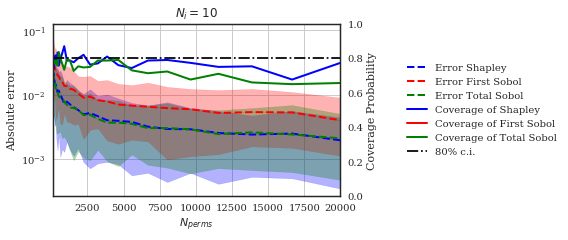

In [6]:
# Coverage probability
ci_prob = 0.20
error_type = 'absolute'
logscale = True
name = 'N_{perms}'
legend = True
ci_method = 'tlc'

do_cover = False
if n_boot > 1 or method == 'random':
    do_cover = True

if name == 'N_i':
    x_ticks = all_n_inner
    x_axes = all_n_perms
    name_axes = 'N_{perms}'
    axis = 0
else:
    x_ticks = all_n_perms
    x_axes = all_n_inner
    name_axes = 'N_i'
    axis = 1

n_col = len(x_axes)

fig, axes = plt.subplots(1, n_col, figsize=(2.5*n_col+3, 3.5), sharex=True, sharey=True)    
axes = [axes] if n_col == 1 else axes

for i_ax, (N, ax_err) in enumerate(zip(x_axes, axes)):
    
    # Take the associated result
    results = {
        'Shapley': all_shapley_results.take(i_ax, axis=axis),
        'First Sobol': all_first_results.take(i_ax, axis=axis),
        'Total Sobol': all_total_results.take(i_ax, axis=axis)
    }
    
    results_SE = {
        'Shapley': all_shapley_results_SE.take(i_ax, axis=axis),
        'First Sobol': all_first_results_SE.take(i_ax, axis=axis),
        'Total Sobol': all_total_results_SE.take(i_ax, axis=axis)
    }
            
    # Error plot
    plot_error(results, true_results, x_ticks, ax=ax_err, error_type=error_type, logscale=logscale)

    # Cover ax
    ax_cov = ax_err.twinx()
    ax_cov.set_ylim(0., 1.)
    
    # Cover plot
    if do_cover:
        plot_cover(results, true_results, x_ticks, results_SE=results_SE, ax=ax_cov, ci_prob=ci_prob,
                  ci_method=ci_method)
        # Labels
        if i_ax < n_col - 1:
            plt.setp(ax_cov.get_yticklabels(), visible=False)
            ax_cov.set_ylabel('')
            ax_cov.set_yticks([])
            
    # Labels
    if i_ax > 0:
        plt.setp(ax_err.get_yticklabels(), visible=False)
        ax_err.set_ylabel('')
        
    # Others
    ax_err.set_xlabel('$%s$' % (name))
    ax_err.grid()
    ax_err.set_title('$%s = %d$' % (name_axes, N))
    
    # Legends
    if i_ax == n_col-1:
        h_err, l_err = ax_err.get_legend_handles_labels()
        h_cov, l_cov = ax_cov.get_legend_handles_labels()
        if legend:
            ax_err.legend(h_err + h_cov, l_err + l_cov, loc='center left', 
                          bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
if savefigs:
    name = './output/additive_gaussian_precision_dim_%d_%s_nboot_%d' % (dim, method, n_boot)
    name += '_nNperms_%d_nNi_%d_rho_%.2f_Nv_%d_maxNperms_%d_nrun_%d_%s.pdf' %\
        (n_n_perms, n_n_inner, corr, n_var, max_n_perms, n_run, error_type)
    fig.savefig(name)